In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import import_preprocess, baseline_models
from importlib import reload
reload(import_preprocess)
reload(baseline_models)

from import_preprocess import ImportPreprocess, convert_labels_to_string, convert_labels_to_int
from baseline_models import XGBoostClassifier, MajorityClassClassifier, RuleBasedClassifier, NaiveBayesClassifier, LogisticRegression, LSTM_Model, get_all_predictions

In [23]:
import_preprocess = ImportPreprocess()
import_preprocess.import_train_val_test()
import_preprocess.create_balanced_dataset()

X_train, y_train, S_train, y_train_multi = import_preprocess.X_train, import_preprocess.y_train, import_preprocess.S_train, import_preprocess.y_train_multi
X_val, y_val, S_val, y_val_multi = import_preprocess.X_val, import_preprocess.y_val, import_preprocess.S_val, import_preprocess.y_val_multi
X_test, y_test, S_test, y_test_multi = import_preprocess.X_test, import_preprocess.y_test, import_preprocess.S_test, import_preprocess.y_test_multi
X_balanced, y_balanced = import_preprocess.X_train_balanced, import_preprocess.y_train_balanced

print("Number of training samples:", len(X_train)) 
print("Number of validation samples:", len(X_val))
print("Number of test samples:", len(X_test)) 
print("Number of balanced samples:", len(X_balanced))

Number of training samples: 14000
Number of validation samples: 2000
Number of test samples: 4000
Number of balanced samples: 10000


In [24]:
results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall'])
balanced_results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall'])

In [25]:
y_train = convert_labels_to_int(y_train)
y_balanced = convert_labels_to_int(y_balanced)
y_val = convert_labels_to_int(y_val)

In [26]:
y_train[:3]

[0, 0, 0]

a) hateBERT

In [32]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

class HateBERTModel:
    def __init__(self):
        self.model = BertForSequenceClassification.from_pretrained("GroNLP/hateBERT", num_labels=2)
        self.tokenizer = BertTokenizer.from_pretrained("GroNLP/hateBERT")
            
    def prepare_X(self, X):
        """Generates encoded padded tensors from the input data"""
        X_text = [' '.join(tokens) for tokens in X]
        encoded = [self.tokenizer.encode(text) for text in X_text]
        padded = pad_sequence([torch.tensor(seq) for seq in encoded], batch_first=True, padding_value=self.tokenizer.pad_token_id)
        return padded
    
    def prepare_dataset(self, X, y=None):
        """Create a PyTorch dataset from the input data"""
        class TextDataset(Dataset):
            def __init__(self, X, y=None):
                self.X = X
                self.y = y
            
            def __len__(self):
                return len(self.X)
            
            def __getitem__(self, idx):
                if self.y is not None:
                    return self.X[idx], self.y[idx]
                return self.X[idx]
        return TextDataset(X, y)
    
    
    def train(self, X_train, y_train, X_dev, y_dev, epochs=3, batch_size=32, lr=5e-5):
        X_train = self.prepare_X(X_train)
        X_dev = self.prepare_X(X_dev)
        
        train_dataset = self.prepare_dataset(X_train, y_train)
        dev_dataset = self.prepare_dataset(X_dev, y_dev)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        dev_loader = DataLoader(dev_dataset, batch_size=batch_size)
        
        #self.model.to('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Define optimizer and loss function
        optimizer = AdamW(self.model.parameters(), lr=lr)
        loss_fn = torch.nn.CrossEntropyLoss()
        
        # Training loop
        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            for batch in train_loader:
                optimizer.zero_grad()   
                X_batch, y_batch = batch
                #X_batch = X_batch.to('cuda' if torch.cuda.is_available() else 'cpu')
                #y_batch = torch.tensor(y_batch).to('cuda' if torch.cuda.is_available() else 'cpu')
                
                outputs = self.model(X_batch, labels=y_batch)
                loss = outputs.loss
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")
            
            # Validation
            self.model.eval()
            all_preds = []
            all_labels = []
            with torch.no_grad():
                for batch in dev_loader:
                    X_batch, y_batch = batch
                    X_batch = X_batch.to('cuda' if torch.cuda.is_available() else 'cpu')
                    outputs = self.model(X_batch)
                    preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                    all_preds.extend(preds)
                    all_labels.extend(y_batch.numpy())
            
            acc = accuracy_score(all_labels, all_preds)
            print(f"Validation Accuracy: {acc:.4f}")
    
    def predict(self, X):
        X = self.prepare_X(X)
        dataset = self.prepare_dataset(X)
        data_loader = DataLoader(dataset, batch_size=32)
        
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for batch in data_loader:
                batch = batch.to('cuda' if torch.cuda.is_available() else 'cpu')
                outputs = self.model(batch)
                preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                predictions.extend(preds)
        
        return predictions

In [33]:
model = HateBERTModel()
model.train(X_train[:3000], y_train[:3000], X_val[:1000], y_val[:1000])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\jogip\OneDrive - TU Wien\Master\Natural Language Processing\NLP_24W_VSHJ\venv\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Loss: 49.2877
Validation Accuracy: 0.8430
Epoch 2/3, Loss: 29.5136
Validation Accuracy: 0.8420
Epoch 3/3, Loss: 9.9269
Validation Accuracy: 0.8330


In [34]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

def _calculate_print_metrics(y_true, y_pred):
    """
    Calculate and print accuracy, balanced accuracy, precision and recall.
    """
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0.0, pos_label='sexist')
    recall = recall_score(y_true, y_pred, zero_division=0.0, pos_label='sexist')

    print(f"accuracy: {accuracy:.4f}")
    print(f"balanced accuracy: {balanced_accuracy:.4f}")
    print(f"precision: {precision:.4f}")
    print(f"recall: {recall:.4f}")
    return accuracy, balanced_accuracy, precision, recall

def evaluate(model, X, y_true):
    """
    Evaluate the model on train and validation sets.
    Metrics: accuracy, balanced accuracy, precision, recall.
    """
    y_pred = model.predict(X)

    y_pred = convert_labels_to_string(y_pred)
    y_true = convert_labels_to_string(y_true)

    print("#" * 40 + "\n")
    _calculate_print_metrics(y_true, y_pred)
    print("\n" + "#" * 40 + "\n")

    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["0 - not sexist", "1 - sexist"], yticklabels=["0 - not sexist", "1 - sexist"])
    plt.title(f'Confusion matrix')
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.show()
    
    return results



########################################

accuracy: 0.8330
balanced accuracy: 0.7128
precision: 0.7881
recall: 0.4685

########################################



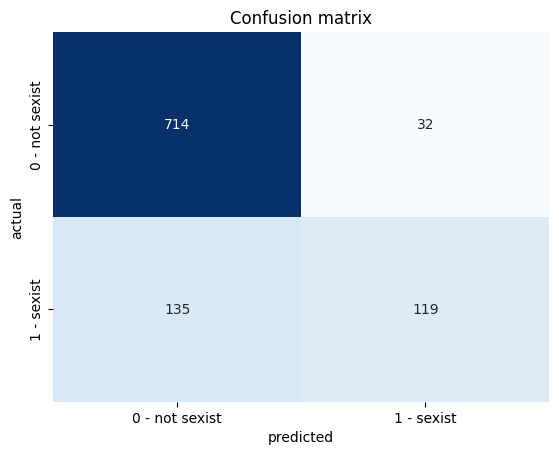

,Model,Dataset,Accuracy,Balanced_Accuracy,Precision,Recall


In [35]:
evaluate(model, X_val[:1000], y_val[:1000])

In [36]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
import time

class DistilBERTModel:
    def __init__(self):
        self.model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
        self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
            
    def prepare_X(self, X):
        """Generates encoded padded tensors from the input data"""
        X_text = [' '.join(tokens) for tokens in X]
        encoded = [self.tokenizer.encode(text) for text in X_text]
        padded = pad_sequence([torch.tensor(seq) for seq in encoded], batch_first=True, padding_value=self.tokenizer.pad_token_id)
        return padded
    
    def prepare_dataset(self, X, y=None):
        """Create a PyTorch dataset from the input data"""
        class TextDataset(Dataset):
            def __init__(self, X, y=None):
                self.X = X
                self.y = y
            
            def __len__(self):
                return len(self.X)
            
            def __getitem__(self, idx):
                if self.y is not None:
                    return self.X[idx], self.y[idx]
                return self.X[idx]
        return TextDataset(X, y)
    
    
    def train(self, X_train, y_train, X_dev, y_dev, epochs=3, batch_size=32, lr=5e-5):
        X_train = self.prepare_X(X_train)
        X_dev = self.prepare_X(X_dev)
        
        train_dataset = self.prepare_dataset(X_train, y_train)
        dev_dataset = self.prepare_dataset(X_dev, y_dev)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        dev_loader = DataLoader(dev_dataset, batch_size=batch_size)
        
        #self.model.to('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Define optimizer and loss function
        optimizer = AdamW(self.model.parameters(), lr=lr)
        loss_fn = torch.nn.CrossEntropyLoss()
        
        # Training loop
        for epoch in range(epochs):
            starting_time = time.time()
            
            self.model.train()
            total_loss = 0
            for batch in train_loader:
                optimizer.zero_grad()   
                X_batch, y_batch = batch
                #X_batch = X_batch.to('cuda' if torch.cuda.is_available() else 'cpu')
                #y_batch = y_batch.to('cuda' if torch.cuda.is_available() else 'cpu')
                
                outputs = self.model(X_batch, labels=y_batch)
                loss = outputs.loss
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")
            
            # Validation
            self.model.eval()
            all_preds = []
            all_labels = []
            with torch.no_grad():
                for batch in dev_loader:
                    X_batch, y_batch = batch
                    X_batch = X_batch.to('cuda' if torch.cuda.is_available() else 'cpu')
                    outputs = self.model(X_batch)
                    preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                    all_preds.extend(preds)
                    all_labels.extend(y_batch.numpy())
            
            acc = accuracy_score(all_labels, all_preds)
            print(f"Validation Accuracy: {acc:.4f}")
            print(f"Time taken: {time.time() - starting_time:.2f}s")
    
    def predict(self, X):
        X = self.prepare_X(X)
        dataset = self.prepare_dataset(X)
        data_loader = DataLoader(dataset, batch_size=32)
        
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for batch in data_loader:
                batch = batch.to('cuda' if torch.cuda.is_available() else 'cpu')
                outputs = self.model(batch)
                preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                predictions.extend(preds)
        
        return predictions

In [37]:
model = DistilBERTModel()
model.train(X_train[:3000], y_train[:3000], X_val[:1000], y_val[:1000])

c:\Users\jogip\OneDrive - TU Wien\Master\Natural Language Processing\NLP_24W_VSHJ\venv\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jogip\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of DistilBertForSequenceClassification were no

Epoch 1/3, Loss: 56.3043
Validation Accuracy: 0.7460
Time taken: 227.23s
Epoch 2/3, Loss: 48.3789
Validation Accuracy: 0.8320
Time taken: 233.31s
Epoch 3/3, Loss: 37.6534
Validation Accuracy: 0.8070
Time taken: 231.96s


########################################

accuracy: 0.8070
balanced accuracy: 0.7577
precision: 0.6117
recall: 0.6575

########################################



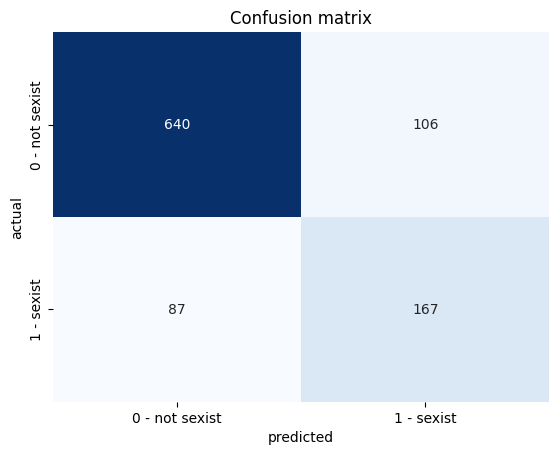

,Model,Dataset,Accuracy,Balanced_Accuracy,Precision,Recall


In [38]:
evaluate(model, X_val[:1000], y_val[:1000])